In [1]:
# Public Health Sentiment Analysis on Social Media
# Tools: Python, NLTK, Scikit-learn, Optional: Hugging Face Transformers
# Dataset: example CSV (e.g., COVID-19 Vaccine Tweets with Sentiment Annotation from Kaggle)

import os
import re
import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.feature_selection import SelectKBest, chi2

# imbalance handling
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore") 


# save/load
import joblib

In [2]:
# visualization defaults
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

RANDOM_STATE = 42


In [3]:
# Edit this path to point to your CSV file. The script accepts common column names.
DATA_PATH = "/media/kibria/624309e6-cae1-4eca-a603-4ebc61fc0d9b/data/archive (2)/covid-19_vaccine_tweets_with_sentiment.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please download and place it in this folder.")

# read CSV (try common encodings)
try:
    df = pd.read_csv(DATA_PATH)
except Exception:
    df = pd.read_csv(DATA_PATH, encoding='latin-1')

print('Raw data shape:', df.shape)
print('Columns:', list(df.columns))


Raw data shape: (6000, 3)
Columns: ['tweet_id', 'label', 'tweet_text']


In [4]:
# ---------------------------
# Try to find text & label columns
text_cols = [c for c in df.columns if c.lower() in ('text','tweet','content','message')]
label_cols = [c for c in df.columns if 'sentiment' in c.lower() or 'label'==c.lower() or c.lower()=='target']

if len(text_cols) == 0:
    # attempt fuzzy fallback
    for alt in ['full_text','tweet_text','clean_text']:
        if alt in df.columns:
            text_cols = [alt]
            break

if len(label_cols) == 0:
    for alt in ['sentiment_label','sentiment_value']:
        if alt in df.columns:
            label_cols = [alt]
            break

if len(text_cols) == 0 or len(label_cols) == 0:
    raise ValueError('Could not detect text or label columns automatically. Please ensure your CSV has a text column and a sentiment/label column.')

TEXT_COL = text_cols[0]
LABEL_COL = label_cols[0]
print('Using text column:', TEXT_COL)
print('Using label column:', LABEL_COL)


Using text column: tweet_text
Using label column: label


In [5]:
# keep only relevant columns
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL: 'text', LABEL_COL: 'sentiment'})

# drop missing
df = df.dropna(subset=['text','sentiment']).reset_index(drop=True)

# If sentiment is numeric or codes, map to categorical strings for clarity
if pd.api.types.is_numeric_dtype(df['sentiment']):
    df['sentiment'] = df['sentiment'].astype(str)

# quick check
print('\nAfter clean, sample:')
print(df.head(5))



After clean, sample:
                                                text sentiment
0  4,000 a day dying from the so called Covid-19 ...         1
1  Pranam message for today manifested in Dhyan b...         2
2  Hyderabad-based ?@BharatBiotech? has sought fu...         2
3  Confirmation that Chinese #vaccines "dont hav...         1
4  Lab studies suggest #Pfizer, #Moderna vaccines...         3



Class distribution:
sentiment
2    3680
3    1900
1     420
Name: count, dtype: int64


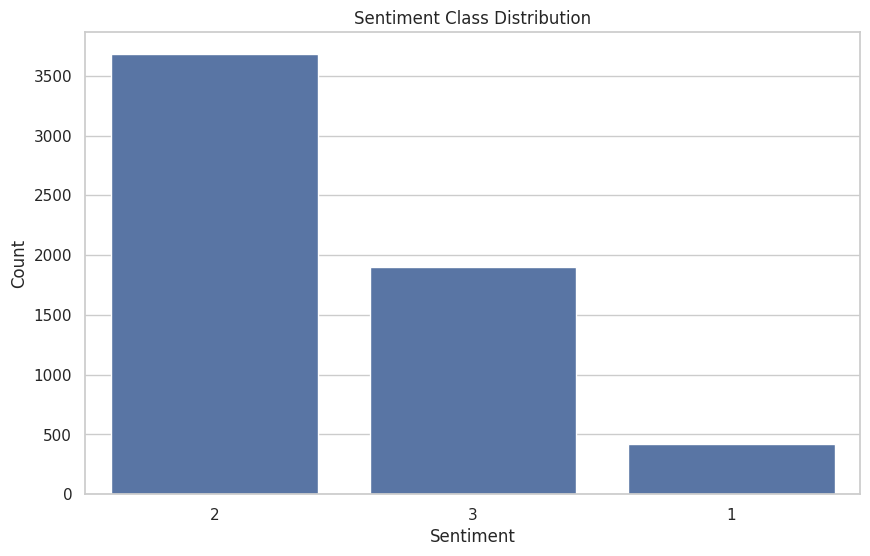

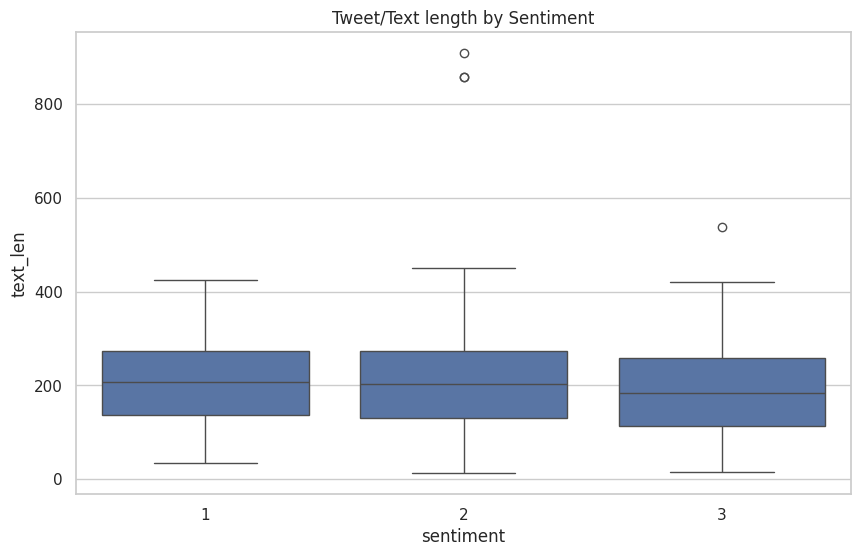

In [6]:
# Class distribution
class_counts = df['sentiment'].value_counts()
print('\nClass distribution:')
print(class_counts)

plt.figure()
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Add text length column for EDA
df['text_len'] = df['text'].astype(str).apply(len)
plt.figure()
sns.boxplot(x='sentiment', y='text_len', data=df)
plt.title('Tweet/Text length by Sentiment')
plt.show()

In [7]:
# Top hashtags
hashtag_re = re.compile(r"#\w+")
all_hashtags = df['text'].astype(str).str.findall(hashtag_re).explode().dropna().str.lower()
if not all_hashtags.empty:
    print('\nTop 20 hashtags:')
    print(all_hashtags.value_counts().head(20))

# Tokenization and top words (quick)
nltk.download('punkt', quiet=True)

tokenizer = TweetTokenizer(reduce_len=True)
# prepare stopwords later after download

# build a word frequency ignoring very common stopwords
try:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))
except Exception:
    stop_words = set()

freq = Counter()
for text in df['text'].astype(str).tolist():
    tokens = tokenizer.tokenize(text.lower())
    for t in tokens:
        if t.isalpha() and t not in stop_words:
            freq[t] += 1

print('\nMost common words (top 30):')
print(freq.most_common(30))



Top 20 hashtags:
text
#moderna              2144
#covid19              1354
#covaxin              1289
#sputnikv             1081
#vaccine               918
#pfizerbiontech        716
#pfizer                620
#covidvaccine          566
#oxfordastrazeneca     345
#astrazeneca           341
#sinopharm             334
#coronavirus           330
#sinovac               328
#covid                 327
#covid19vaccine        287
#covishield            276
#lockdown              198
#vaccinated            191
#vaccines              185
#vaccination           183
Name: count, dtype: int64

Most common words (top 30):
[('vaccine', 2180), ('first', 729), ('covid', 716), ('dose', 681), ('get', 568), ('vaccines', 556), ('got', 538), ('shot', 503), ('today', 471), ('doses', 428), ('people', 348), ('second', 337), ('vaccinated', 324), ('india', 307), ('one', 301), ('new', 295), ('vaccination', 295), ('cases', 278), ('russia', 275), ('effective', 248), ('canada', 245), ('like', 242), ('business', 23

In [8]:
# 5. Preprocessing functions
# ---------------------------
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()
url_re = re.compile(r'https?://\S+|www\.\S+')
user_re = re.compile(r'@\w+')
non_alphanum_re = re.compile(r'[^a-zA-Z\s#]')  # keep hashtags for EDA

try:
    stop_words = set(stopwords.words('english'))
except Exception:
    stop_words = set()


def clean_text(text, keep_hashtags=False):
    text = str(text)
    text = url_re.sub('', text)
    text = user_re.sub('', text)
    text = text.replace('\n', ' ')
    text = non_alphanum_re.sub(' ', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply cleaning (this can take time for large datasets)
print('\nCleaning text (this can take a while depending on the dataset size)...')
start = time.time()
df['clean_text'] = df['text'].apply(lambda t: clean_text(t, keep_hashtags=True))
print(f'Cleaning finished in {time.time()-start:.1f} sec')
print('\nExample cleaned text:')
print(df[['text','clean_text']].head(5))


Cleaning text (this can take a while depending on the dataset size)...
Cleaning finished in 1.8 sec

Example cleaned text:
                                                text  \
0  4,000 a day dying from the so called Covid-19 ...   
1  Pranam message for today manifested in Dhyan b...   
2  Hyderabad-based ?@BharatBiotech? has sought fu...   
3  Confirmation that Chinese #vaccines "dont hav...   
4  Lab studies suggest #Pfizer, #Moderna vaccines...   

                                          clean_text  
0  day dying called covid vaccine report #vaccine...  
1  pranam message today manifested dhyan #truth #...  
2  hyderabad based sought fund government ramp pr...  
3  confirmation chinese #vaccines high protection...  
4  lab study suggest #pfizer #moderna vaccine pro...  


In [9]:
# TF-IDF (unigrams + bigrams)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])
print('\nTF-IDF shape:', X_tfidf.shape)

# VADER lexicon scores (rule-based features)
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()
vader_scores = df['text'].astype(str).apply(lambda t: sia.polarity_scores(t))
vader_df = pd.DataFrame(list(vader_scores)).reset_index(drop=True)

# Meta features
meta_df = pd.DataFrame({
    'text_len': df['text_len'],
    'num_hashtags': df['text'].astype(str).str.count('#'),
    'num_mentions': df['text'].astype(str).str.count('@')
}).reset_index(drop=True)

# Combine into feature matrix (sparse + dense combination)
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, np.array(vader_df), np.array(meta_df)])

# Target encoding
label_categories = df['sentiment'].astype('category')
y = label_categories.cat.codes
label_mapping = dict(enumerate(label_categories.cat.categories))
print('\nLabel mapping:', label_mapping)


TF-IDF shape: (6000, 20000)

Label mapping: {0: '1', 1: '2', 2: '3'}


In [10]:
# 7. Feature selection (chi2) - only on TF-IDF portion

k = min(5000, X_tfidf.shape[1])
selector = SelectKBest(chi2, k=k)
X_tfidf_selected = selector.fit_transform(X_tfidf, y)
print('Selected TF-IDF shape:', X_tfidf_selected.shape)

# Recombine selected features + vader + meta
X = hstack([X_tfidf_selected, np.array(vader_df), np.array(meta_df)])

Selected TF-IDF shape: (6000, 5000)


In [11]:
X_train, X_test, y_train, y_test, df_train_idx, df_test_idx = train_test_split(
    X, y, df.index, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class counts:')
print(pd.Series(y_train).value_counts())

# Optional: apply SMOTE for numerical classifiers that can't accept sparse matrices.
# Demonstration: only if you want to use an algorithm that requires dense input (e.g., KNN)
USE_SMOTE = False
if USE_SMOTE:
    print('Applying SMOTE (converts to dense) ...')
    X_train_dense = X_train.todense()
    sm = SMOTE(random_state=RANDOM_STATE)
    X_train_res, y_train_res = sm.fit_resample(X_train_dense, y_train)
else:
    X_train_res, y_train_res = X_train, y_train



Train shape: (4800, 5007) Test shape: (1200, 5007)
Train class counts:
1    2944
2    1520
0     336
Name: count, dtype: int64


In [12]:
# ---------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'LinearSVC': LinearSVC(max_iter=5000, random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)
}

results = {}
for name, model in models.items():
    print(f'\nTraining {name}...')
    # sklearn accepts sparse matrices for these models
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred, target_names=list(label_mapping.values())))
    results[name] = {'model': model, 'y_pred': y_pred, 'acc': acc}



Training LogisticRegression...
LogisticRegression Accuracy: 0.7375
              precision    recall  f1-score   support

           1       0.33      0.07      0.12        84
           2       0.74      0.91      0.82       736
           3       0.75      0.55      0.63       380

    accuracy                           0.74      1200
   macro avg       0.61      0.51      0.52      1200
weighted avg       0.72      0.74      0.71      1200


Training LinearSVC...
LinearSVC Accuracy: 0.5867
              precision    recall  f1-score   support

           1       0.18      0.52      0.27        84
           2       0.80      0.54      0.64       736
           3       0.57      0.69      0.62       380

    accuracy                           0.59      1200
   macro avg       0.52      0.59      0.51      1200
weighted avg       0.69      0.59      0.61      1200


Training RandomForest...
RandomForest Accuracy: 0.7200
              precision    recall  f1-score   support

         

In [13]:
# 10. Hyperparameter tuning example (Logistic Regression)
# ---------------------------
param_grid = {'C': [0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
clf = GridSearchCV(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE), param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
print('\nBest logistic params:', clf.best_params_)
best_lr = clf.best_estimator_


/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Best logistic params: {'C': 10}


In [14]:
# Evaluate best
y_pred_lr = best_lr.predict(X_test)
print('\nBest Logistic Regression performance:')
print(classification_report(y_test, y_pred_lr, target_names=list(label_mapping.values())))


Best Logistic Regression performance:
              precision    recall  f1-score   support

           1       0.30      0.08      0.13        84
           2       0.75      0.89      0.81       736
           3       0.72      0.58      0.64       380

    accuracy                           0.73      1200
   macro avg       0.59      0.52      0.53      1200
weighted avg       0.71      0.73      0.71      1200



In [15]:
# Save best model
joblib.dump(best_lr, 'best_logistic_model.joblib')
# Save vectorizer & selector to reconstruct pipeline
joblib.dump({'vectorizer': vectorizer, 'selector': selector}, 'vectorizer_selector.joblib')


['vectorizer_selector.joblib']

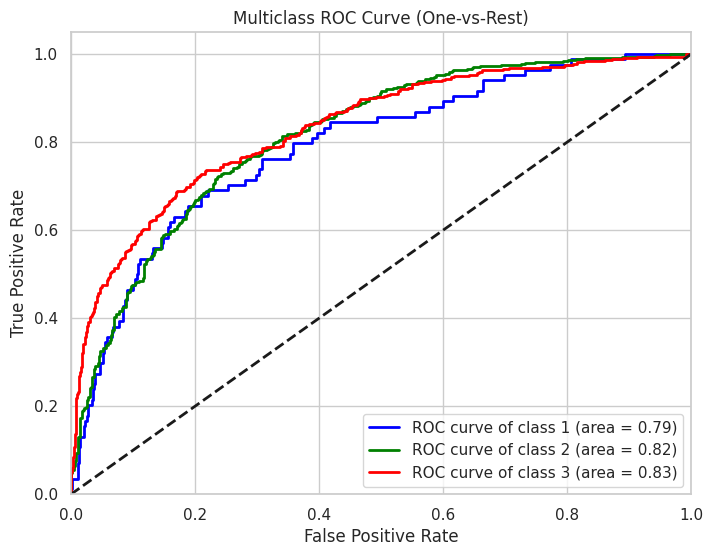

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
if len(label_mapping) > 2:
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=list(label_mapping.keys()))
    n_classes = y_test_bin.shape[1]

    # Get probability scores for each class
    if hasattr(best_lr, "predict_proba"):
        y_score = best_lr.predict_proba(X_test)
    elif hasattr(best_lr, "decision_function"):
        y_score = best_lr.decision_function(X_test)
        # decision_function shape may vary; ensure shape (n_samples, n_classes)
        if y_score.ndim == 1:
            y_score = y_score.reshape(-1, 1)
    else:
        raise AttributeError("Model has neither predict_proba nor decision_function")

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC curve of class {label_mapping[i]} (area = {roc_auc[i]:0.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

In [17]:
# Hypothesis example 1 (two-class case): "Mean tweet length differs between class A and class B"
from scipy.stats import ttest_ind, chi2_contingency

unique_codes = np.unique(y)
if len(unique_codes) >= 2:
    a, b = unique_codes[0], unique_codes[1]
    a_lens = df.loc[df.index.isin(df_train_idx) | df.index.isin(df_test_idx)][df['sentiment'].astype('category').cat.codes == a]['text_len']
    b_lens = df.loc[df.index.isin(df_train_idx) | df.index.isin(df_test_idx)][df['sentiment'].astype('category').cat.codes == b]['text_len']
    tstat, pval = ttest_ind(a_lens, b_lens, equal_var=False)
    print(f"T-test for text length between labels {label_mapping[a]} and {label_mapping[b]}: t={tstat:.3f}, p={pval:.3e}")

# Hypothesis example 2: Are hashtags associated with sentiment? (Chi-square)
hashtag_presence = (df['text'].astype(str).str.count('#') > 0).astype(int)
cont_table = pd.crosstab(hashtag_presence, df['sentiment'])
chi2, p, dof, ex = chi2_contingency(cont_table)
print('Chi-square test for hashtag presence vs sentiment: chi2=%.3f p=%.3e' % (chi2, p))


T-test for text length between labels 1 and 2: t=1.273, p=2.036e-01
Chi-square test for hashtag presence vs sentiment: chi2=0.000 p=1.000e+00


In [18]:
if hasattr(best_lr, 'coef_'):
    # Need to map selected TF-IDF features back to original feature names
    tf_feature_names = np.array(vectorizer.get_feature_names_out())
    # selector.get_support gives mask of original tfidf features kept
    support_mask = selector.get_support()
    selected_feature_names = tf_feature_names[support_mask]

    coef = best_lr.coef_
    # multiclass: coef_ shape (n_classes, n_features_total) or (n_classes, n_features)
    # our coefficients correspond to entire feature set (selected tfidf + vader + meta). We will show contribution from TF-IDF only.
    n_tfidf_selected = selected_feature_names.shape[0]
    for class_idx, class_name in label_mapping.items():
        if coef.ndim == 1:
            class_coef = coef
        else:
            class_coef = coef[class_idx]
        tfidf_coefs = class_coef[:n_tfidf_selected]
        top_pos = np.argsort(tfidf_coefs)[-20:][::-1]
        top_neg = np.argsort(tfidf_coefs)[:20]
        print(f"\nTop positive TF-IDF features for class '{label_mapping[class_idx]}' (top 20):")
        print(list(selected_feature_names[top_pos]))



Top positive TF-IDF features for class '1' (top 20):
['oxfordastrazeneca', 'clot', 'astrazeneca', 'people', 'blood', 'blood clot', 'death', 'pfizer', 'died', 'body', 'oxford', 'pfizervaccine', 'pfizer moderna', 'anyone', 'kicked', 'south', 'taking', 'report', 'reaction', 'less effective']

Top positive TF-IDF features for class '2' (top 20):
['sputnikv', 'eu', 'covaxin', 'dos', 'order', 'million', 'like', 'minister', 'pm', 'supply', 'know', 'state', 'citizen', 'modi', 'sinovac', 'shot moderna', 'health', 'trudeau', 'shipment', 'home']

Top positive TF-IDF features for class '3' (top 20):
['vaccinated', 'efficacy', 'getvaccinated', 'done', 'get', 'got', 'thank', 'grateful', 'fully', 'effective', 'fully vaccinated', 'vaccination', 'vaccinated moderna', 'vaccinessavelives', 'today', 'show', 'covidvacccine', 'thanks', 'vaccineswork', 'business']


In [19]:
RUN_TRANSFORMER = False
if RUN_TRANSFORMER:
    from datasets import Dataset
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
    model_name = 'distilbert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare dataset
    ds = Dataset.from_pandas(df[['clean_text','sentiment']].rename(columns={'clean_text':'text'}))
    # encode labels
    ds = ds.class_encode_column('sentiment')
    def tokenize_fn(ex):
        return tokenizer(ex['text'], truncation=True, padding='max_length', max_length=128)
    ds = ds.map(tokenize_fn, batched=True)
    ds = ds.train_test_split(test_size=0.2, stratify_by_column='sentiment', seed=RANDOM_STATE)

    num_labels = len(ds['train'].features['sentiment'].names)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir='./transformer_out',
        evaluation_strategy='epoch',
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        save_total_limit=1,
        seed=RANDOM_STATE,
        logging_steps=50
    )

    def compute_metrics_eval(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            'accuracy': (preds == labels).astype(np.float32).mean().item()
        }

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds['train'],
        eval_dataset=ds['test'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_eval
    )

    trainer.train()
    trainer.save_model('distilbert_sentiment_model')

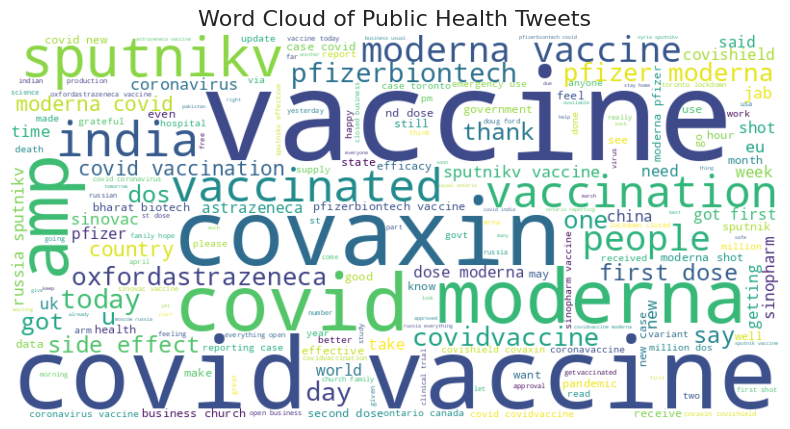

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned text for WordCloud
all_text = " ".join(df['clean_text'])

# Create and display WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Public Health Tweets', fontsize=16)
plt.show()
